# __Gaussian fitting demo__

In [1]:
from numpy import array, exp, linspace, sqrt, pi
import matplotlib.pyplot as plt

Suppose we are given the following dataset:

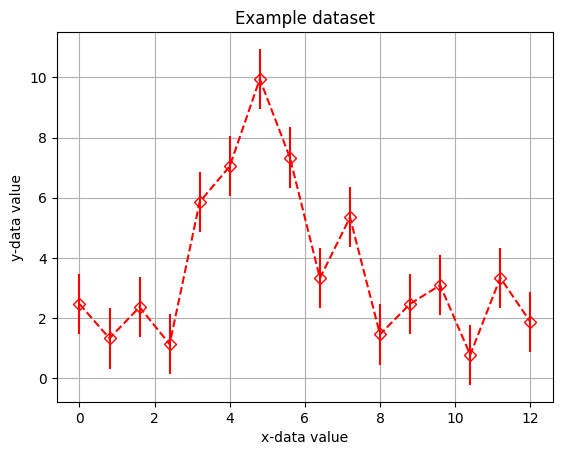

In [2]:
x_data = array([
    0.00, 0.80, 1.60, 2.40, 3.20, 4.00, 4.80, 5.60,
    6.40, 7.20, 8.00, 8.80, 9.60, 10.4, 11.2, 12.0
])

y_data = array([
    2.473, 1.329, 2.370, 1.135, 5.861, 7.045, 9.942, 7.335,
    3.329, 5.348, 1.462, 2.476, 3.096, 0.784, 3.342, 1.877
])

y_error = array([
    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
])

plt.errorbar(x_data, y_data, yerr=y_error, ls='dashed', marker='D', c='red', markerfacecolor='none')
plt.title('Example dataset')
plt.ylabel('y-data value')
plt.xlabel('x-data value')
plt.grid()
plt.show()

And our model $F(x)$ for this dataset is a Gaussian plus a constant background such that
$$
F(x) = \frac{A}{w\sqrt{2\pi}}\exp{\left(-\frac{1}{2}\frac{(x-c)^2}{w^2}\right)} + b
$$
where our model parameters are the area under the gaussian $A$, the width $w$, center $c$ and background $b$.

In this notebook we're going to:

 - Construct a likelihood distribution using the model and our dataset.
 - Construct a prior distribution for the model parameters.
 - Combine the likelihood and prior to create a posterior distribution.
 - Sample from the posterior using MCMC.
 - Use the sample to make inferences about the model parameters.


## __Constructing the likelihood__
The first step is to implement our model. For simple models like this one this can be done using just a function, but as models become more complex it is becomes useful to build them as classes. Here we implement the model as the `PeakModel` class, where by defining the `__call__` instance method, an instance of `PeakModel` can be called as a function to return a prediction of the y-data values.

In [3]:
class PeakModel:
    def __init__(self, x_data):
        """
        The __init__ should be used to pass in any data which is required
        by the model to produce predictions of the y-data values.
        """
        self.x = x_data

    def __call__(self, theta):
        return self.forward_model(self.x, theta)

    @staticmethod
    def forward_model(x, theta):
        """
        The forward model must make a prediction of the experimental data we would expect to measure
        given a specific set model parameters 'theta'.
        """
        # unpack the model parameters
        area, width, center, background = theta
        # calculate and return the prediction of the y-data values
        z = (x - center) / width
        gaussian = exp(-0.5 * z**2) / (sqrt(2 * pi) * width)
        return area * gaussian + background

Inference-tools has a variety of likelihood classes which allow you to easily construct a likelihood function given the measured data and your forward-model.

As in this example we assume the errors on the y-data values to be Gaussian, we use the `GaussianLikelihood` class from the `likelihoods` module:

In [4]:
from inference.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood(
    y_data=y_data,
    sigma=y_error,
    forward_model=PeakModel(x_data)
)

Instances of the likelihood classes can be called as functions, and return the log-likelihood when passed a vector of model parameters:

In [5]:
initial_guess = array([10., 2., 5., 2.])
guess_log_likelihood = likelihood(initial_guess)
print(guess_log_likelihood)

-54.31604287484006


We could at this stage pair the likelihood object with an optimiser in order to obtain
the maximum-likelihood estimate of the parameters. In this example however, we want to
construct the posterior distribution for the model parameters, and that means we need to
define a prior.

## __Constructing the prior__

In the common case that the prior distribution for each model variable is independent of the others
(i.e. the prior over all variables can be written as a product of priors over each individual variable)
the `inference.priors` module has tools which allow us to build a prior easily.

Which model parameters are assigned to a given prior is specified using the indices of those parameters 
(i.e. the position they hold in the parameter vector as defined in the `PeakModel` class we wrote earlier).

Suppose we want the area, width and background parameters of the model to each have an
exponential prior. The indices of the area, width and background parameters are `[0, 1, 3]`
respectively, and we pass these indices to the `ExponentialPrior` class via the `variable_indices`
argument:

In [6]:
from inference.priors import ExponentialPrior
exp_prior = ExponentialPrior(beta=[50., 20., 20.], variable_indices=[0, 1, 3])

We can assign the 'center' parameter a uniform distribution in the same way using the `UniformPrior` class:

In [7]:
from inference.priors import UniformPrior
uni_prior = UniformPrior(lower=0., upper=12., variable_indices=[2])

Now we use the `JointPrior` class to combine the various components into a single prior
distribution which covers all the model parameters:

In [8]:
from inference.priors import JointPrior
prior_components = [exp_prior, uni_prior]
prior = JointPrior(components=prior_components, n_variables=4)

All priors constructed using `inference.priors` classes have an associated `sample()` method which allows sampling directly from the prior:

In [9]:
prior_sample = prior.sample()
print(prior_sample)

[95.64495063  7.57341208  6.01526054 57.40371404]


## __Sampling from the posterior__
The likelihood and prior can be easily combined into a posterior distribution
using the `Posterior` class:

In [10]:
from inference.posterior import Posterior
posterior = Posterior(likelihood=likelihood, prior=prior)

Now we have constructed a posterior distribution, we can sample from it
using Markov-chain Monte-Carlo (MCMC).

The `inference.mcmc` module contains implementations of various MCMC sampling algorithms.
Here we import the `PcaChain` class and use it to create a Markov-chain object:

In [11]:
from inference.mcmc import PcaChain
chain = PcaChain(posterior=posterior, start=initial_guess)

We generate samples by advancing the chain by a chosen number of steps using the `advance` method:

In [12]:
chain.advance(25000)

  advancing chain:   [ complete - 25000 steps taken in 0:00:03 ]      


We can check the status of the chain using the `plot_diagnostics` method:

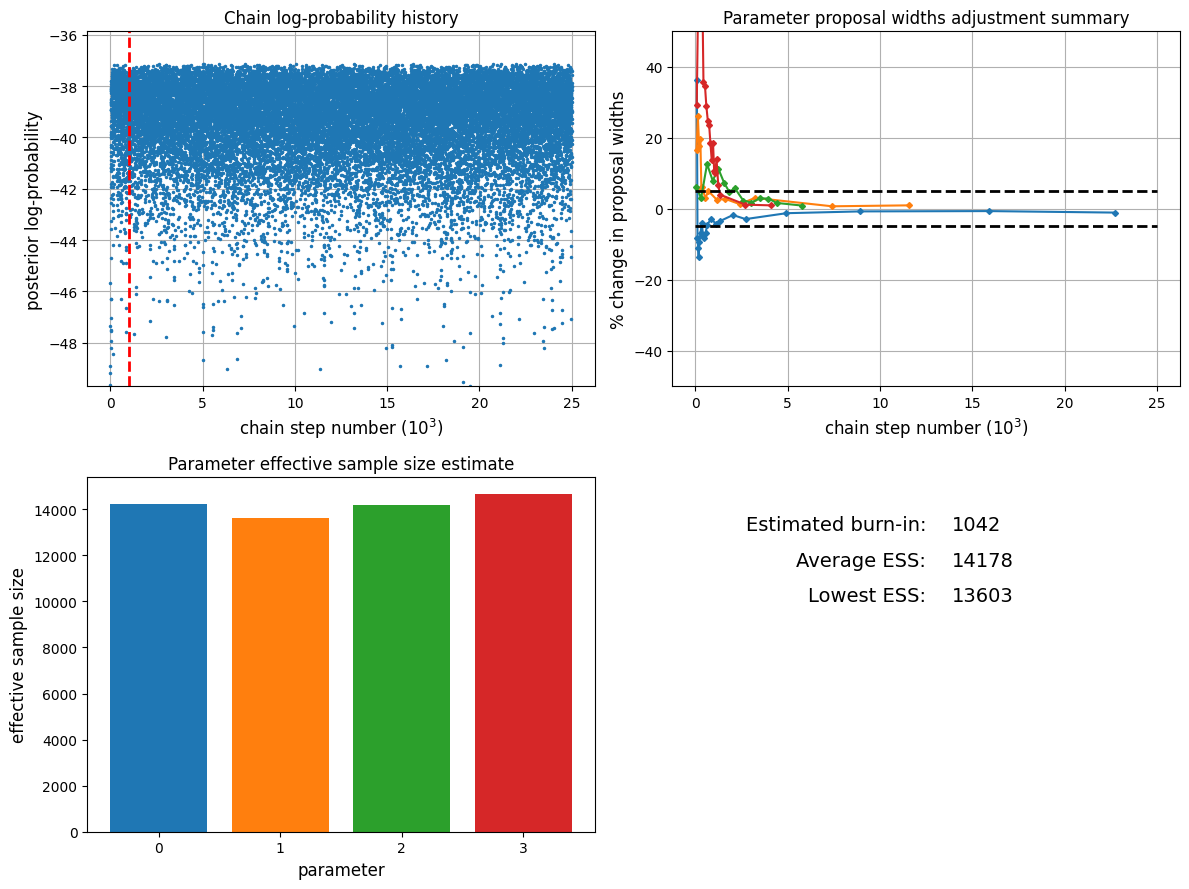

In [13]:
chain.plot_diagnostics()

It can also be useful to plot the value of each parameter over each step in the chain. This can be done using the `trace_plot` method:

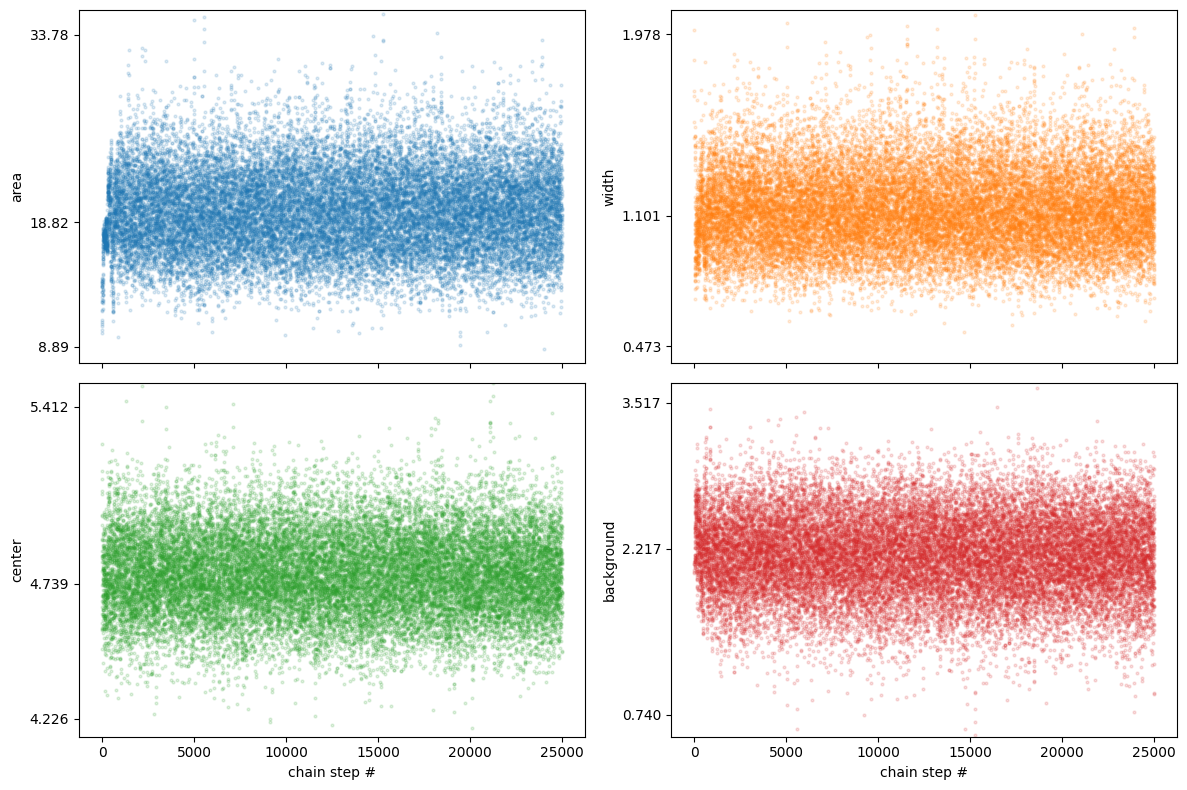

In [14]:
labels=['area', 'width', 'center', 'background']
chain.trace_plot(labels=labels)

The burn-in (how many samples from the start of the chain are discarded) can be passed as a keyword argument to methods which access or process the sample data, such as `get_probabilities()` or `get_sample()`.

Here we pick a value for the burn-in based on the diagnostics:

In [15]:
burn = 1500

## __Using the sample to infer the model parameters__

We can get a overview of the posterior using the `matrix_plot` method
of chain objects, which plots all possible 1D & 2D marginal distributions
of the full parameter set (or a chosen sub-set).

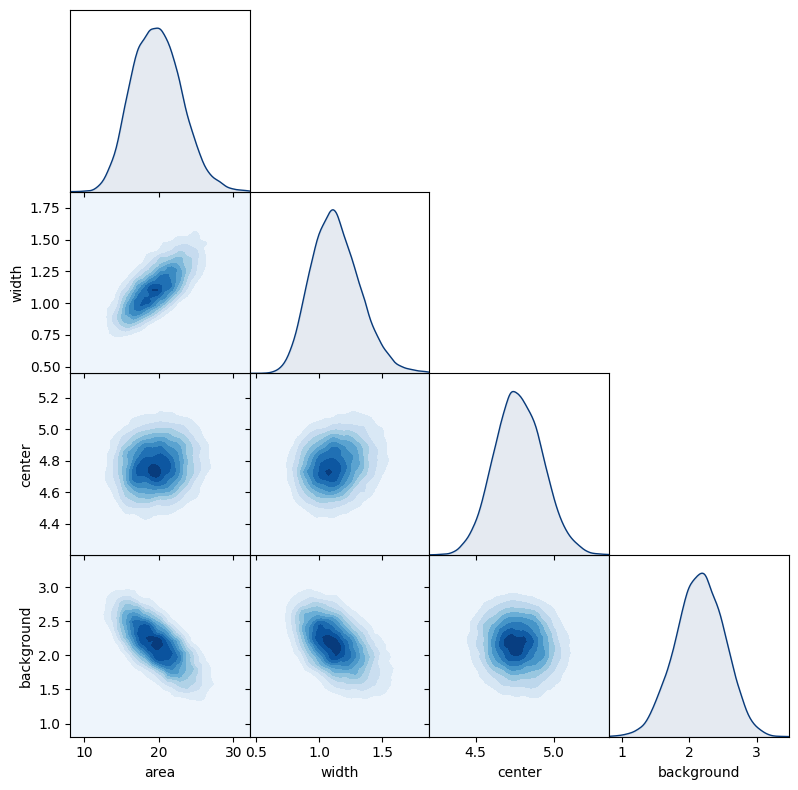

In [16]:
chain.matrix_plot(labels=labels, burn=burn)

We can easily estimate 1D marginal distributions for any parameter
using the `get_marginal` method:

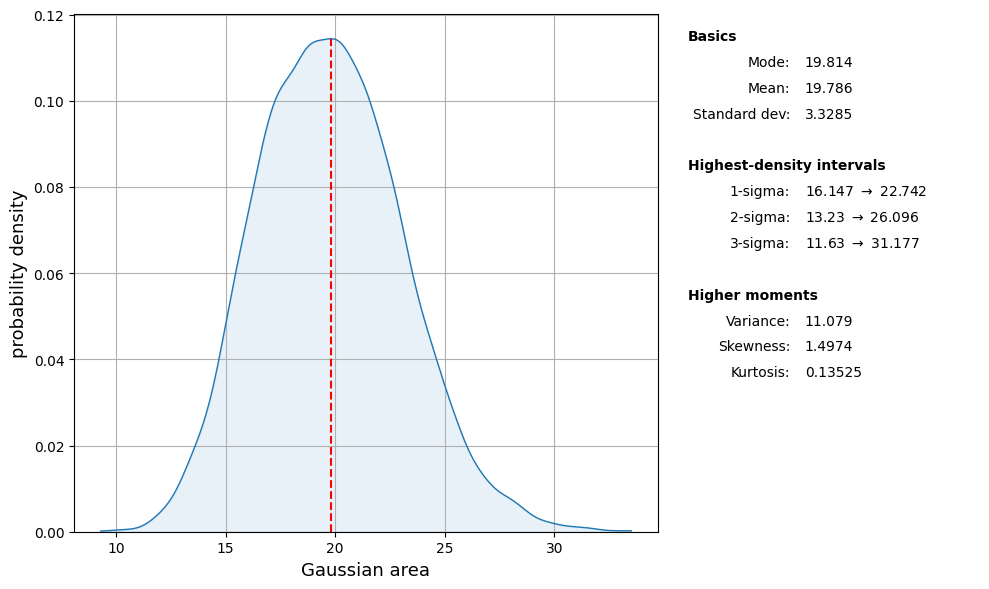

In [17]:
area_pdf = chain.get_marginal(0, burn=burn)
area_pdf.plot_summary(label='Gaussian area')

We can assess the level of uncertainty in the model predictions by passing each sample
through the forward-model and observing the distribution of model expressions that result:

In [18]:
# generate an axis on which to evaluate the model
x_fits = linspace(-1, 13, 500)
# get the sample
sample = chain.get_sample(burn=burn)
# pass each through the forward model
curves = array([PeakModel.forward_model(x_fits, theta) for theta in sample])

We could plot the predictions for each sample all on a single graph, but this is
often cluttered and difficult to interpret.

A better option is to use the `hdi_plot` function from the `plotting` module to plot
highest-density intervals for each point where the model is evaluated:

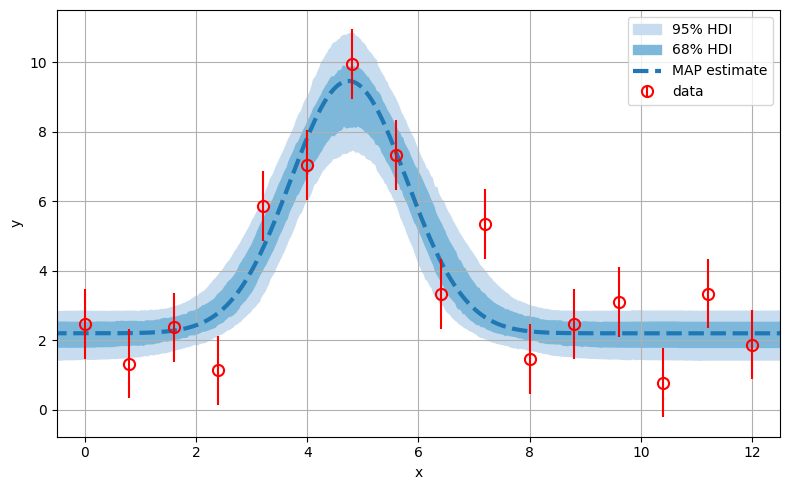

In [19]:
from inference.plotting import hdi_plot
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)
hdi_plot(x_fits, curves, intervals=[0.68, 0.95], axis=ax)

# plot the MAP estimate (the sample with the single highest posterior probability)
MAP_prediction = PeakModel.forward_model(x_fits, chain.mode())
ax.plot(x_fits, MAP_prediction, ls='dashed', lw=3, c='C0', label='MAP estimate')
# build the rest of the plot
ax.errorbar(
    x_data, y_data, yerr=y_error, linestyle='none', c='red', label='data',
    marker='o', markerfacecolor='none', markeredgewidth=1.5, markersize=8
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-0.5, 12.5])
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()